##### 1.Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("C:/Users/harik/Data science Assignment/EastWestAirlines.xlsx", sheet_name="data")

print(df.shape)
df.head()

(3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [3]:
df.isnull().sum()

ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [4]:
df = df.drop(columns=["ID#"])

##### 2.Remove Outliers

In [5]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (2875, 11)


##### 3.Feature Scaling

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

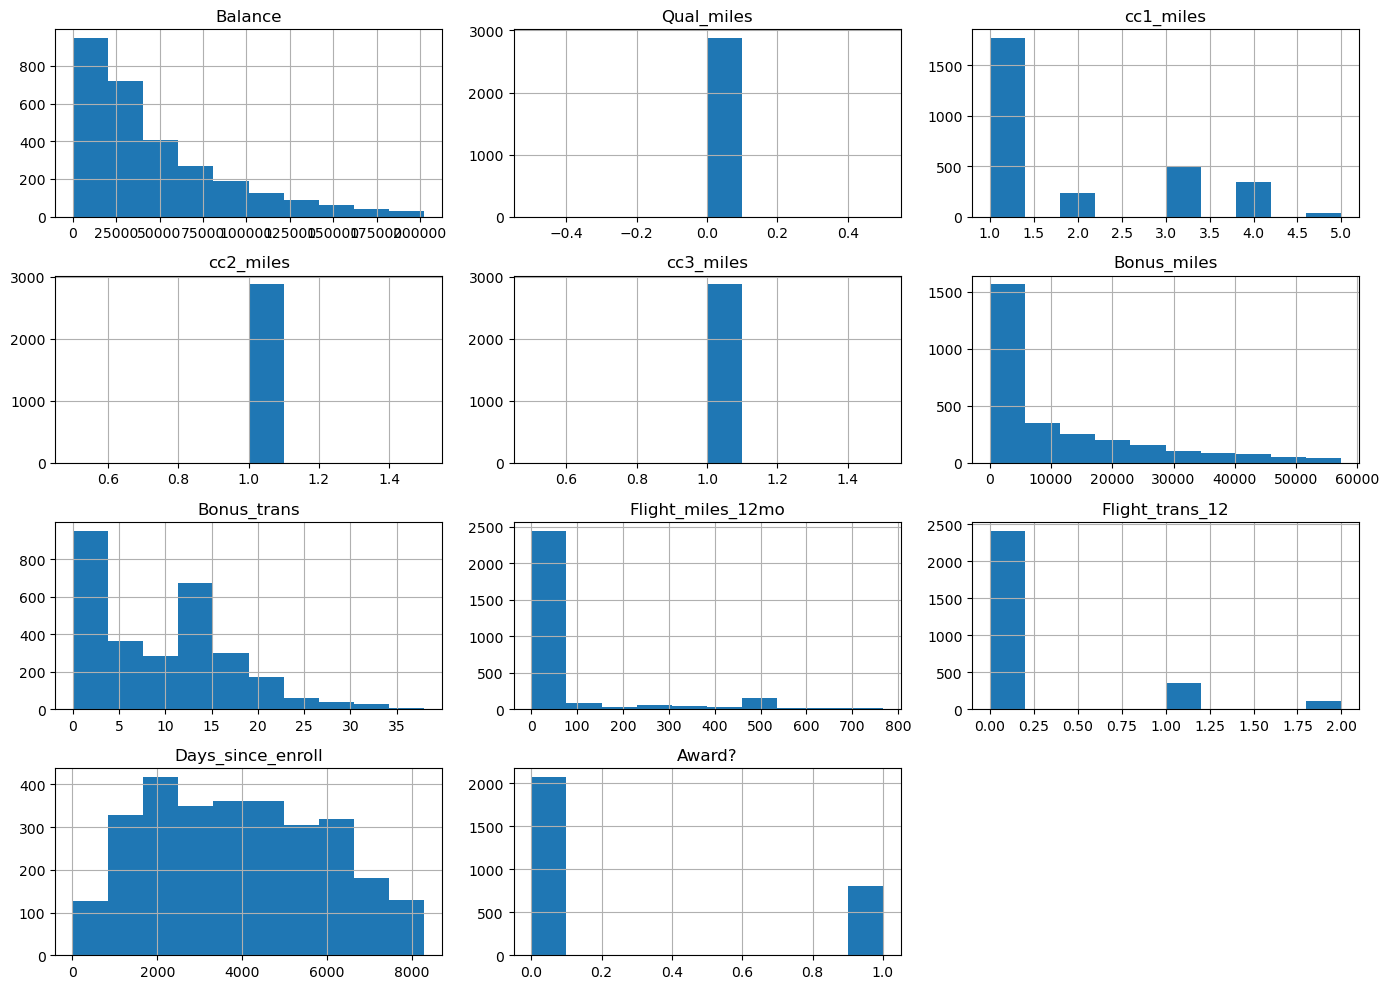

In [8]:
df.hist(figsize=(14,10))
plt.tight_layout()
plt.show()

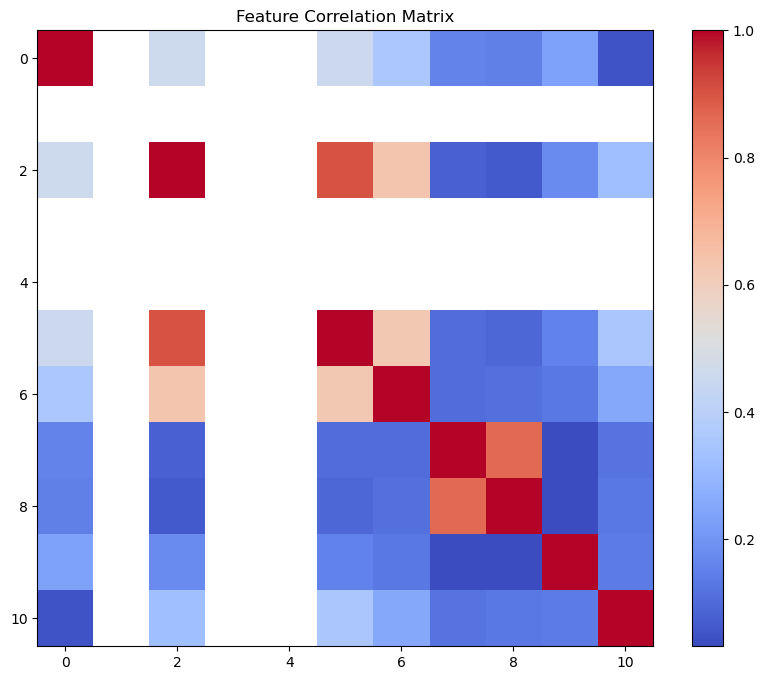

In [9]:
plt.figure(figsize=(10,8))
plt.imshow(df.corr(), cmap="coolwarm")
plt.colorbar()
plt.title("Feature Correlation Matrix")
plt.show()

##### 4.K-Means Clustering

In [10]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

###### a) Elbow Method

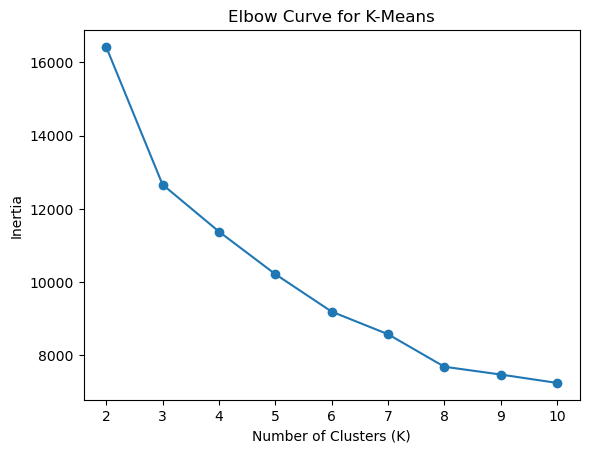

In [11]:
inertia = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.plot(range(2,11), inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Curve for K-Means")
plt.show()


###### b) Apply K-Means

In [12]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

df["KMeans_Cluster"] = kmeans_labels

###### c) K-Means Evaluation

In [13]:
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
print("K-Means Silhouette Score:", kmeans_silhouette)

K-Means Silhouette Score: 0.22962827467448732


###### d) K-Means Visualization

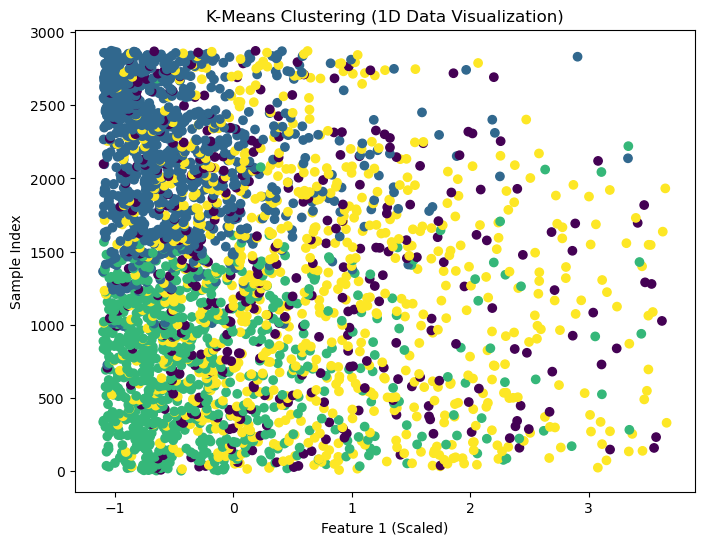

In [14]:
plt.figure(figsize=(8, 6))

# Plot using index on Y-axis
plt.scatter(
    scaled_data[:, 0],
    range(len(scaled_data)),
    c=kmeans_labels,
    cmap='viridis'
)

plt.title("K-Means Clustering (1D Data Visualization)")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Sample Index")
plt.show()

###### e) Cluster Interpretation

In [15]:
df.groupby("KMeans_Cluster").mean()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
KMeans_Cluster,,,,,,,,,,,
0,65113.991501,0.0,2.065156,1.0,1.0,14463.011331,11.756374,428.084986,1.308782,4098.711048,0.447592
1,25552.377339,0.0,1.092516,1.0,1.0,2772.070686,5.465696,4.810811,0.038462,2068.735967,0.107069
2,36146.795071,0.0,1.138781,1.0,1.0,3479.610895,6.156939,4.203632,0.036316,5642.370947,0.206226
3,75069.773131,0.0,3.299113,1.0,1.0,26368.466413,16.259823,6.510773,0.055767,4439.508238,0.486692


##### 7.DBSCAN Clustering

In [16]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(scaled_data)

df["DBSCAN_Cluster"] = dbscan_labels

In [17]:
# Remove noise points (-1) for silhouette
mask = dbscan_labels != -1

dbscan_silhouette = silhouette_score(
    scaled_data[mask],
    dbscan_labels[mask]
)

print("DBSCAN Silhouette Score:", dbscan_silhouette)

DBSCAN Silhouette Score: 0.26561729508328463


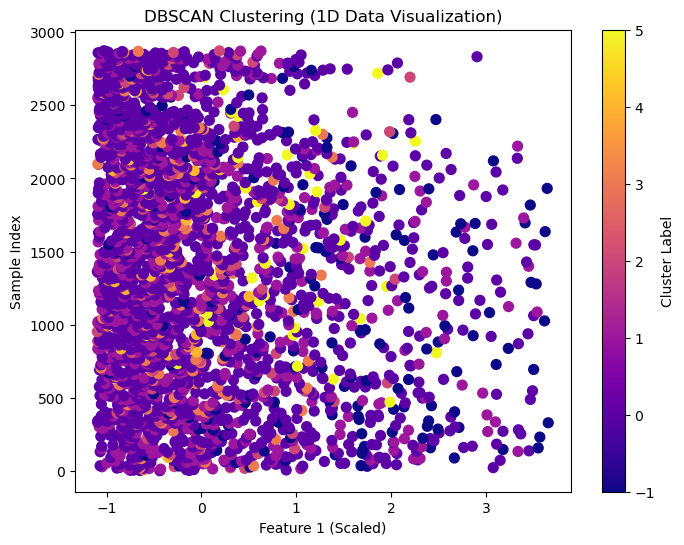

In [18]:
plt.figure(figsize=(8, 6))

plt.scatter(
    scaled_data[:, 0],
    range(len(scaled_data)),   # index used for Y-axis
    c=dbscan_labels,
    cmap='plasma',
    s=50
)

plt.title("DBSCAN Clustering (1D Data Visualization)")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Sample Index")
plt.colorbar(label="Cluster Label")
plt.show()



In [19]:
df["DBSCAN_Cluster"].value_counts()

DBSCAN_Cluster
 0    1804
 1     598
-1     179
 2     120
 3     109
 5      40
 4      25
Name: count, dtype: int64